Korchagina A.A.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt 
import copy

<h4>HMM random generator </h4>
Generate a sequence x of length L given the model parameters.


In [2]:
#A - transition matrix
#E - emission matrix
#X - beginning distribution

def random_generator_states(A, E, L, X): 
    states = np.zeros((L,), dtype = int)
    Xs = len(X)
    M = len(A)
    K = len(E[0])
    for i in range(L):
        r = random.random()
        f = 0
        if i == 0:
            for j in range(Xs):
                f += X[j]
                if r < f:
                    states[i] = j
                    break
        else:
            for j in range(M):
                f += A[states[i-1], j]
                if r < f:
                    states[i] = j
                    break
    return states

def random_generator(A, E, L, X):
    x = np.zeros((L,), dtype = int)
    states = random_generator_states(A, E, L, X)
    K = len(E[0])
    for i in range(L):
        r = random.random()
        f = 0
        for j in range(K):
            f += E[states[i], j]
            if r < f:
                x[i] = j+1
                break
    return x, states


<h4> Viterbi algorithm </h4>

Use Viterbi algorithm to find the most probable path π given x and HMM parameters.  
Using formulas from "Biological sequence analysis" R.Durbin p.55

In [3]:
#seq - sequence x
#A - transition matrix
#E - emission matrix
#X - beginning distribution

def Viterby_algoritm(seq, A, E, X):
    L = len(seq)
    M = len(A)
    
    #matrix of the most probable previous state in every current state
    Ptr = np.zeros((M,L), dtype = int)
    
    #matrix of the biggest probability in every current state 
    W = np.zeros((M,L))
    
    #matrix of the most probable state path
    P_final = np.zeros((L,), dtype = int)
    
    for i in range(L):
        if i == 0:
            for k in range(M):
                W[k, i] = X[k] * E[k, seq[i]-1]
        else:
            for j in range(M):
                max_el = -1.0
                imax = -1
                for k in range(M):
                    S = E[j, seq[i]-1]*A[k,j]*W[k, i-1]
                    if S > max_el:
                        max_el = S
                        imax = k
                W[j,i] = max_el
                Ptr[j,i] = imax
        W[:, i] /= max(W[:, i])
    
    #Traceback
    for i in range(L-1,-1,-1):
        if i == L-1:
            imax = -1
            max_el = -1.0
            for k in range(M):
                if W[k,i] > max_el:
                    max_el = W[k,i]
                    imax = k
            P_final[i] = imax
        else:
            P_final[i] = Ptr[P_final[i+1],i+1]
    return P_final
    

<h4>Forward algorithm </h4>

Find the probability P(x) using forward algorithm (store the full matrix of forward
probabilities fk(xi) in order to use it for posterior decoding later on).  
(First part of Viterby)  
Using formulas from "Biological sequence analysis" R.Durbin p.57

In [4]:
#seq - sequence x
#A - transition matrix
#E - emission matrix
#X - beginning distribution

def Forward(seq, A, E, X):
    L = len(seq)
    M = len(A)
    W = np.zeros((M,L))
    
    #vector of normalizaton
    norm = np.zeros(L)
    
    for i in range(L):
        if i == 0:
            for k in range(M):
                W[k, i] = X[k] * E[k, seq[i]-1]
        else:
            for j in range(M):
                S = 0.
                for k in range(M):
                    S += A[k,j]*W[k, i-1]*E[j, seq[i]-1]
                W[j,i] = S
        norm[i] = max(W[:, i])
        W[:, i] /= norm[i]
        
    P_final = 0
    for j in range(M):
        P_final += W[j, L-1]

        
    return W, P_final, norm

<h4>Backward algorithm </h4>

Implement the backward algorithm.   
Using formulas from "Biological sequence analysis" R.Durbin p.58

In [5]:
#seq - sequence x
#A - transition matrix
#E - emission matrix
#X - beginning distribution

def Backward(seq, A, E, X):
    L = len(seq)
    M = len(A)
    W = np.zeros((M,L))
    
    #vector of normalizaton
    norm = np.zeros(L)
    norm[-1] = 1
    for i in range(L-1,-1,-1):
        if i == L-1:
            for k in range(M):
                W[k, i] = 1
        else:
            for j in range(M):
                summ = 0.
                for k in range(M):
                    summ += E[k, seq[i+1]-1]*A[j,k]*W[k, i+1]
                W[j,i] = summ
        norm[i] = max(W[:, i])
        W[:, i] /= norm[i]
        
    P_final = 0.
    for i in range(M):
            P_final += W[i,0]*X[i]*E[i, seq[0]-1]
        
    return W, P_final, norm

<h4>Posterior decoding </h4>

Implement the posterior decoding.   
Using formulas from "Biological sequence analysis" R.Durbin p.59

In [6]:
#F,B - normalized matrix of forward and backward algorithms 
#norm_F, norm_B - vectors of normalization coefficients 
#P - normalized probability of observation

def Posterior(F, B, norm_F, norm_B, P):
    L = len(F)
    P_final = np.zeros(L)
    for i in range(L):
        P_final[i] = np.exp(np.log(F[i]) + np.log(B[i]) - np.log(P)
                            - np.sum(np.log(norm_F[i+1:])) + np.sum(np.log(norm_B[i:])))
    return P_final

<h4> The beginning distribution </h4>
The beginning distribution is the stationary distribution of the underlying Markov chain.  

- Solve the equation xA = x, where x is the beginning distribution
- with condition sum(x(i) = 1)

In [7]:
def begin_dist(A):
    n = len(A)
    A = A.transpose()[:-1] - np.eye(n)[0]      #Choose first equation of matrix
    A = np.vstack((A, np.ones(n)))             #Add condition sum(x(i) = 1)
    b = np.eye(n)[-1]                          #Create matrix of right-hand side matrix
    X = np.linalg.solve(A,b)
    return X

 <h4>Baum-Welch algorithm</h4>
 
 Implement Baum-Welch training.
 Using formulas from "Biological sequence analysis" R.Durbin p.63

In [8]:
#sum of logarithm from hint in homework document
def sum_of_log(X, Y):
    return X + np.log(1 + np.exp(Y-X))

#normalize matrix
def norm_matrix(x):
    m = len(x)
    l = len(x[0])
    
    for i in range(m):
        s = 0.
        for j in range(l):
            s+= x[i,j]
        x[i] /= s
    return x

In [15]:
#A, E - matrix of transitions and matrix of emissions for generation sequences
#A0, E0 - random matrixes of transitions and emissions
#size - count of sequences
#L - length of sequences
#eps - accuracy

def Baum_Welch(A, E, A0, E0, size, L, eps):
    M = len(A)
    
    A_prev = copy.deepcopy(A0)
    E_prev = copy.deepcopy(E0)
    
    A_result = np.zeros((M,M))
    E_result = np.zeros((M,R))
    
    ROLLS = []
    for i in range(size):
        ROLLS.append(random_generator(A, E, L, begin_dist(A))[0])
    X = begin_dist(A0)
    it = 0
    while (1):
        P = np.zeros(M)
        A_final = np.zeros((M,M))
        E_final = np.zeros((M,R))
        sum_log_P = 0
        for i in range(size):
            
            
            A_cur = np.zeros((M,M))
            E_cur = np.zeros((M,R))
            
            FA, PF, nF = Forward(ROLLS[i], A_prev, E_prev, X)
            BA, PB, nB = Backward(ROLLS[i], A_prev, E_prev, X)
            log_P = np.log(PF) + np.sum(np.log(nF))
            sum_log_P += log_P
            for k in range(L-1):
                
                log_Forward = np.log(FA[:,k])
                for m in range(k+1):
                    log_Forward += np.log(nF[m])
                    
                log_Backward = np.log(BA[:,k+1])
                h = k+1
                while(h<L):
                    log_Backward += np.log(nB[h])
                    h+=1
                    
                log_sum = (np.zeros((M,M)) + log_Forward.reshape(M,1) + np.log(A_prev) + 
                           log_Backward + np.log(E_prev[:, ROLLS[i][k+1]-1]) - log_P)
                
                if k == 0:
                    A_cur = log_sum
                else:
                    A_cur = sum_of_log(A_cur, log_sum)
                        
            for k in range(L):
                
                log_Forward = np.log(FA[:,k])
                for m in range(k+1):
                    log_Forward += np.log(nF[m])
                             
                log_Backward = np.log(BA[:,k])
                h = copy.deepcopy(k)
                while(h<L):
                    log_Backward += np.log(nB[h])
                    h+=1
                
                log_sum = log_Forward + log_Backward - log_P
                
                if (E_cur[:, ROLLS[i][k]-1] == np.zeros(M)).all():
                    E_cur[:, ROLLS[i][k]-1] = log_sum                
                else:
                    E_cur[:, ROLLS[i][k]-1] = sum_of_log(E_cur[:, ROLLS[i][k]-1], log_sum)

            if i == 0 :
                P = np.log(BA[:,0])+np.sum(np.log(nB))-log_P
                #print(P)
                A_final = copy.deepcopy(A_cur)
                E_final = copy.deepcopy(E_cur)
            else:
                P = sum_of_log(P, np.log(BA[:,0])+np.sum(np.log(nB))-log_P)
                #print(P)
                A_final = sum_of_log(A_final, A_cur)
                E_final = sum_of_log(E_final, E_cur)
                    
        A_final = norm_matrix(np.exp(A_final))
        E_final = norm_matrix(np.exp(E_final))
        
        For_compare_A = abs(np.log(A_final/A_prev))
        For_compare_E = abs(np.log(E_final/E_prev))
            
        if ((For_compare_A < np.ones((M,M))*eps).all() and 
            (For_compare_E < np.ones((M,R))*eps).all()):
            A_result = copy.deepcopy(A_final)
            E_result = copy.deepcopy(E_final)
            break 
            
        A_prev = copy.deepcopy(A_final)
        E_prev = copy.deepcopy(E_final)
        
        
        s = sum_of_log(P[0],P[1])
        X = np.exp(P - s)
        if it == 0:
            print('Complete credibility of every 10-th iteration:')
        if it % 10 == 0:
            print(sum_log_P)
        it += 1
    return A_result, E_result

# Miserable casino

1) Set transition (M ×M) and emission (M ×K) matrices and beginning distribution (vector of length M).  
Simulate occasionally unfair casino: one dice has equal probabilities of each face
P(i) = 1/6, i = 1, 2, 3, 4, 5, 6 and another dice has probability P(6) = 0.5 and all
other outcomes have probability 0.1. The probability to switch from the fair dice
to the loaded dice is 0.05, the probability to switch from the loaded to the fair dice
is 0.1. The beginning distribution is the stationary distribution of the underlying
Markov chain.

In [10]:
A = np.array([[0.95, 0.05],[0.1, 0.9]])
E = np.array([[1/6,1/6,1/6,1/6,1/6,1/6],[0.1,0.1,0.1,0.1,0.1,0.5]])
X = begin_dist(A)
print('A:', np.around(A, decimals = 2), 'E:', np.around(E, decimals = 2), 'X:', np.around(X, decimals = 2), sep = '\n')

A:
[[ 0.95  0.05]
 [ 0.1   0.9 ]]
E:
[[ 0.17  0.17  0.17  0.17  0.17  0.17]
 [ 0.1   0.1   0.1   0.1   0.1   0.5 ]]
X:
[ 0.67  0.33]


In [11]:
RG = random_generator(A, E, 1000, begin_dist(A))
print(RG[0])

[1 6 1 3 6 3 4 4 4 6 5 4 6 4 6 6 4 6 3 4 2 1 3 4 5 2 2 4 3 5 2 2 4 1 2 4 3
 3 4 4 5 4 6 6 6 5 3 4 2 5 2 5 6 6 6 2 3 5 6 3 1 5 2 5 5 2 3 1 3 6 4 6 4 1
 6 2 5 6 5 6 4 5 4 1 3 5 5 6 4 3 4 6 2 1 3 1 3 4 6 4 4 4 5 3 4 3 2 2 1 4 1
 5 3 6 3 5 3 6 6 2 4 4 2 4 3 3 3 6 6 6 3 1 6 6 6 4 1 1 3 5 6 2 4 1 4 6 4 6
 5 5 2 5 5 3 5 5 3 3 3 2 6 5 2 4 1 2 2 4 3 1 4 3 1 6 5 6 3 4 4 6 1 5 1 1 5
 2 1 1 5 4 6 6 3 4 1 6 6 5 1 4 2 2 4 3 6 1 1 6 5 3 5 3 6 2 6 5 1 3 5 2 3 4
 5 4 6 1 6 3 2 3 4 5 6 6 2 4 1 4 2 4 5 4 2 4 3 5 6 3 6 3 5 6 2 6 3 1 5 6 6
 6 2 3 6 2 6 6 3 6 3 6 2 1 6 4 1 2 6 6 6 4 6 2 2 2 1 1 5 2 5 2 1 3 5 5 6 4
 3 2 2 6 4 5 2 3 3 6 6 2 5 5 3 2 5 4 6 2 4 1 2 4 2 4 6 6 5 6 6 4 3 6 1 6 1
 5 6 4 5 2 2 1 4 2 5 1 6 5 3 1 5 6 4 6 6 1 5 5 3 2 1 6 2 6 5 6 6 6 3 2 6 6
 6 2 6 6 6 4 1 1 3 6 1 3 6 4 4 6 4 3 1 1 4 3 6 4 5 1 5 3 2 5 3 4 1 4 2 2 4
 5 2 3 1 1 5 4 5 1 5 2 2 6 2 6 5 3 3 6 5 6 2 4 5 6 4 1 4 3 4 6 1 1 6 4 3 1
 5 4 1 4 5 1 2 4 1 5 4 1 3 4 2 3 2 6 4 6 6 6 2 5 4 5 4 3 5 6 6 5 6 6 3 3 2
 6 6 5 1 6 5 1 6 6 2 1 1 

2) Compare the simulated path and Viterbi most likely path

In [12]:
VA = Viterby_algoritm(RG[0], A, E, X)
SP = RG[1]
sum = 0
for i in range(len(VA)):
    if RG[1][i] == VA[i]:
        sum +=1
print('The same states/Попадания:', sum/len(VA))

The same states/Попадания: 0.796


Compare the forward path and backward path

In [13]:
FA = Forward(RG[0], A, E, X)
BA = Backward(RG[0], A, E, X)

#log(P)+ sum(log(norm(i)))
#Normalized probability of observation * vector of normalization coefficients(every element)
print(np.log(FA[1]) + np.sum(np.log(FA[2])))
print(np.log(BA[1]) + np.sum(np.log(BA[2])))

-1763.5400535
-1763.5400535


3) Plot posterior probability P(fair). Compare with the regions of the simulated
path where loaded dice was used.

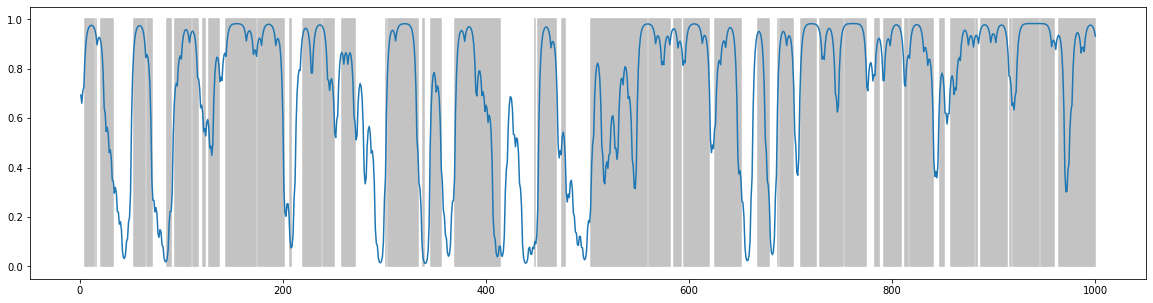

In [14]:
AP = Posterior(FA[0][0], BA[0][0], FA[2], BA[2], FA[1])
L = len(AP)
Sim = RG[1]
#print Posterior probability P(fair)
M = 2
fig = plt.figure()
res = np.zeros((L,M))
for m in range(L):
    res[m] = [m+1,AP[m]]
    
for i in range(L):
    if Sim[i] == 0:
        plt.plot([i+1,i+1], [0,1], color = 'silver')
            
plt.plot(res[:,0], res[:,1])

fig.set_figwidth(20)
fig.set_figheight(5)
plt.show()

In [17]:
M = len(E)
R = len(E.transpose())
while(1):
    A0 = np.around(norm_matrix(np.random.random((M,M))), decimals = 2)
    E0 = np.around(norm_matrix(np.random.random((M,R))), decimals = 2)
    if (A0 != np.zeros((M,M))).all() and (E0 != np.zeros((M,R))).all():
        print('A0:', A0, 'E0:', E0, sep = '\n')
        break

A0:
[[ 0.67  0.33]
 [ 0.3   0.7 ]]
E0:
[[ 0.14  0.15  0.08  0.32  0.23  0.08]
 [ 0.05  0.2   0.22  0.03  0.12  0.38]]


__Example 1:__  
n = 10  
L = 100  
eps = 0.001  

In [18]:
n = 10     #count of sequences
L = 200    #length of sequences
eps = 0.001  #epsilon
BW = Baum_Welch(A, E, A0, E0, n, L, eps)
print('eps =', eps)
print('A:\n', np.around(BW[0], decimals = 2))
print('E:\n', np.around(BW[1], decimals = 2))

Complete credibility of every 10-th iteration:
-3557.33992936
-3498.39906419
-3493.27958388
-3492.17146113
-3491.05278389
-3489.66563634
-3488.00597588
-3486.23548774
-3484.72011306
-3483.77298744
-3483.34600649
-3483.19716706
-3483.15342244
-3483.14187469
-3483.13904338
eps = 0.001
A:
 [[ 0.95  0.05]
 [ 0.09  0.91]]
E:
 [[ 0.15  0.17  0.18  0.18  0.18  0.15]
 [ 0.12  0.09  0.11  0.12  0.08  0.49]]


__Example 2:__  
n = 20  
L = 200  
eps = 0.001

In [19]:
n = 10     #count of sequences
L = 500    #length of sequences
eps = 0.001  #epsilon

BW = Baum_Welch(A, E, A0, E0, n, L, eps)
print('eps =', eps)
print('A:\n', np.around(BW[0], decimals = 2))
print('E:\n', np.around(BW[1], decimals = 2))

eps = 0.001
A:
 [[ 0.96  0.04]
 [ 0.07  0.93]]
E:
 [[ 0.18  0.14  0.16  0.17  0.16  0.18]
 [ 0.09  0.11  0.09  0.11  0.11  0.47]]


__Example 3:__  
n = 20  
L = 200  
eps = 0.001

In [ ]:
n = 20     #count of sequences
L = 200    #length of sequences
eps = 0.001  #epsilon

BW = Baum_Welch(A, E, A0, E0, n, L, eps)
print('eps =', eps)
print('A:\n', np.around(BW[0], decimals = 2))
print('E:\n', np.around(BW[1], decimals = 2))

eps = 0.001
A:
 [[ 0.95  0.05]
 [ 0.1   0.9 ]]
E:
 [[ 0.18  0.18  0.16  0.15  0.16  0.17]
 [ 0.1   0.09  0.09  0.1   0.12  0.5 ]]


We can see, that with new parametrs algorithm works much better. If increase accuracy(eps) or increase count or length of sequences algorithm will work better and better, but it takes much time.